In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import sys
base_dir = os.path.join(os.getcwd(), os.pardir, os.pardir)
sys.path.append(base_dir)

# Models
import Models.LatentFactorModels 
import Simulators.Simulator 
import Models.ModelComparer 
import numpy as np
import sklearn

import pandas as pd
pd.set_option('max_rows', 15)
import seaborn as sns

# Assessment Machinery
eval_base_dir = os.path.join(base_dir, os.pardir, "CancerDimensionalityReduction")
sys.path.append(eval_base_dir)

import Performance.classification.CrossValidation 

# Logging
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Read data

In [3]:
data_object = Performance.classification.CrossValidation.DataFrameCollection(
    independent_data=file("/Users/ijoseph/Code/Data/GradProjects/Cancer-Dimensionality-Reduction/Costello-Methylation/transposed.methlyaton.data.csv"),
    dependent_data=file("/Users/ijoseph/Code/Data/GradProjects/Cancer-Dimensionality-Reduction/Costello-Methylation/hm.indication.csv"))

INFO:root:Reading independent file:<open file '/Users/ijoseph/Code/Data/GradProjects/Cancer-Dimensionality-Reduction/Costello-Methylation/hm.indication.csv', mode 'r' at 0x10bd78660>

INFO:root:Reading independent file:<open file '/Users/ijoseph/Code/Data/GradProjects/Cancer-Dimensionality-Reduction/Costello-Methylation/transposed.methlyaton.data.csv', mode 'r' at 0x10bd74f60>



# Perform Classification

## $L_2$ Logisitc Regression

In [4]:
model = sklearn.linear_model.LogisticRegression(C=1, penalty='l2')

In [6]:
cv_obj = Performance.classification.CrossValidation.CrossValidation \
(dataFrameCollection=data_object, predictorClass=model, k=9)

INFO:root:Fold 2: difference between predicted and acutal:
[1]
vs
Patient.ID
TMZ_4    0
Name: HM.ind, dtype: int64


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


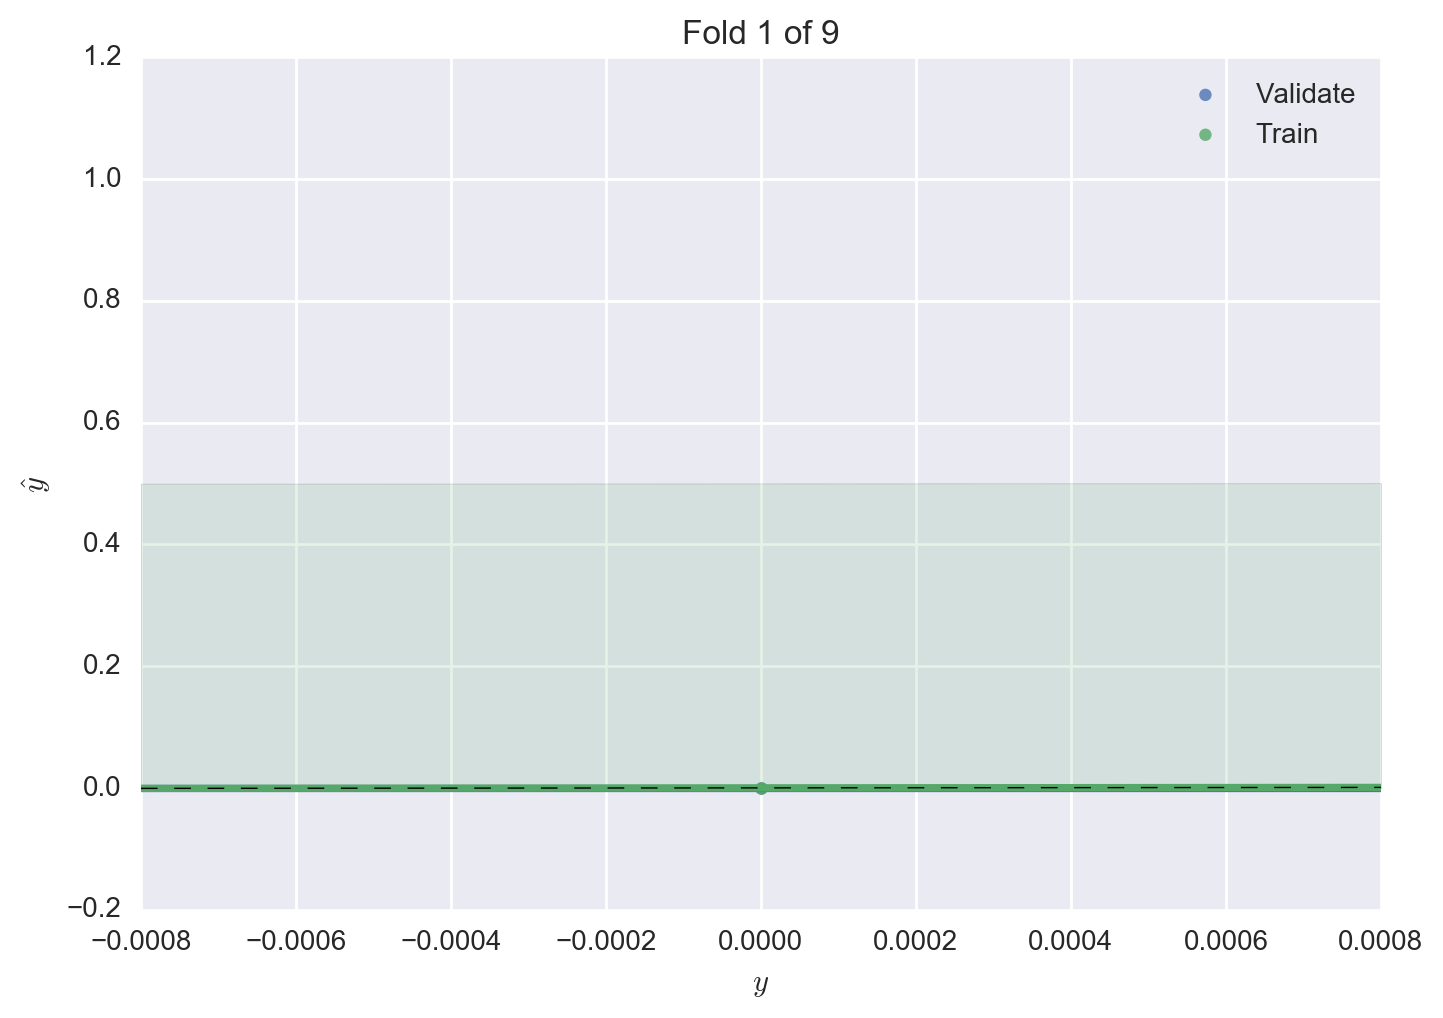

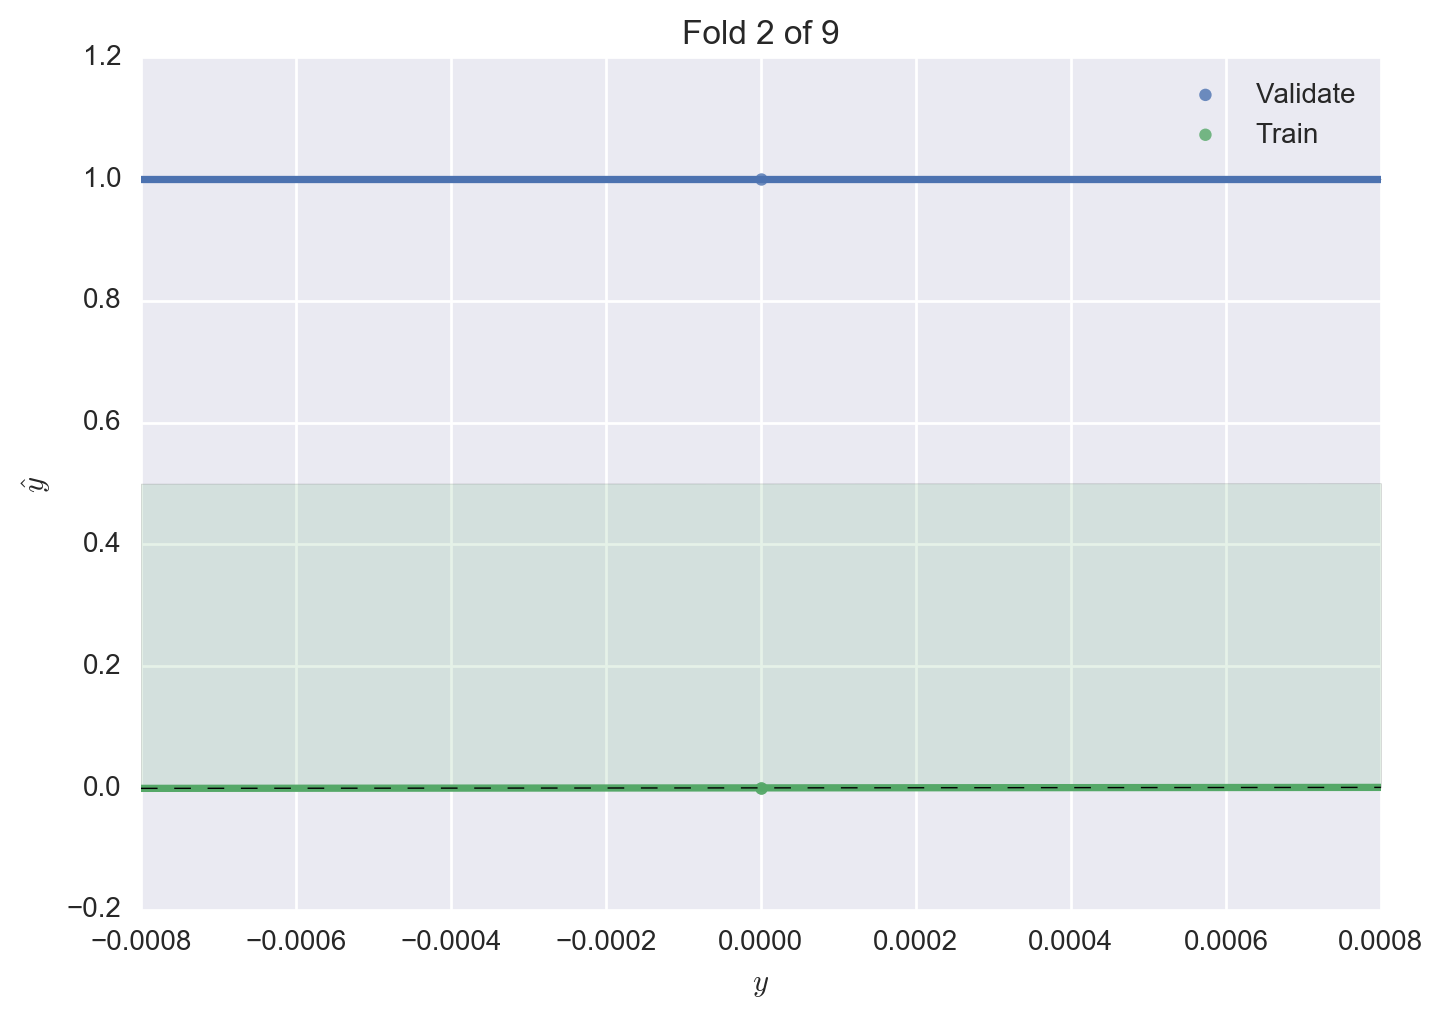

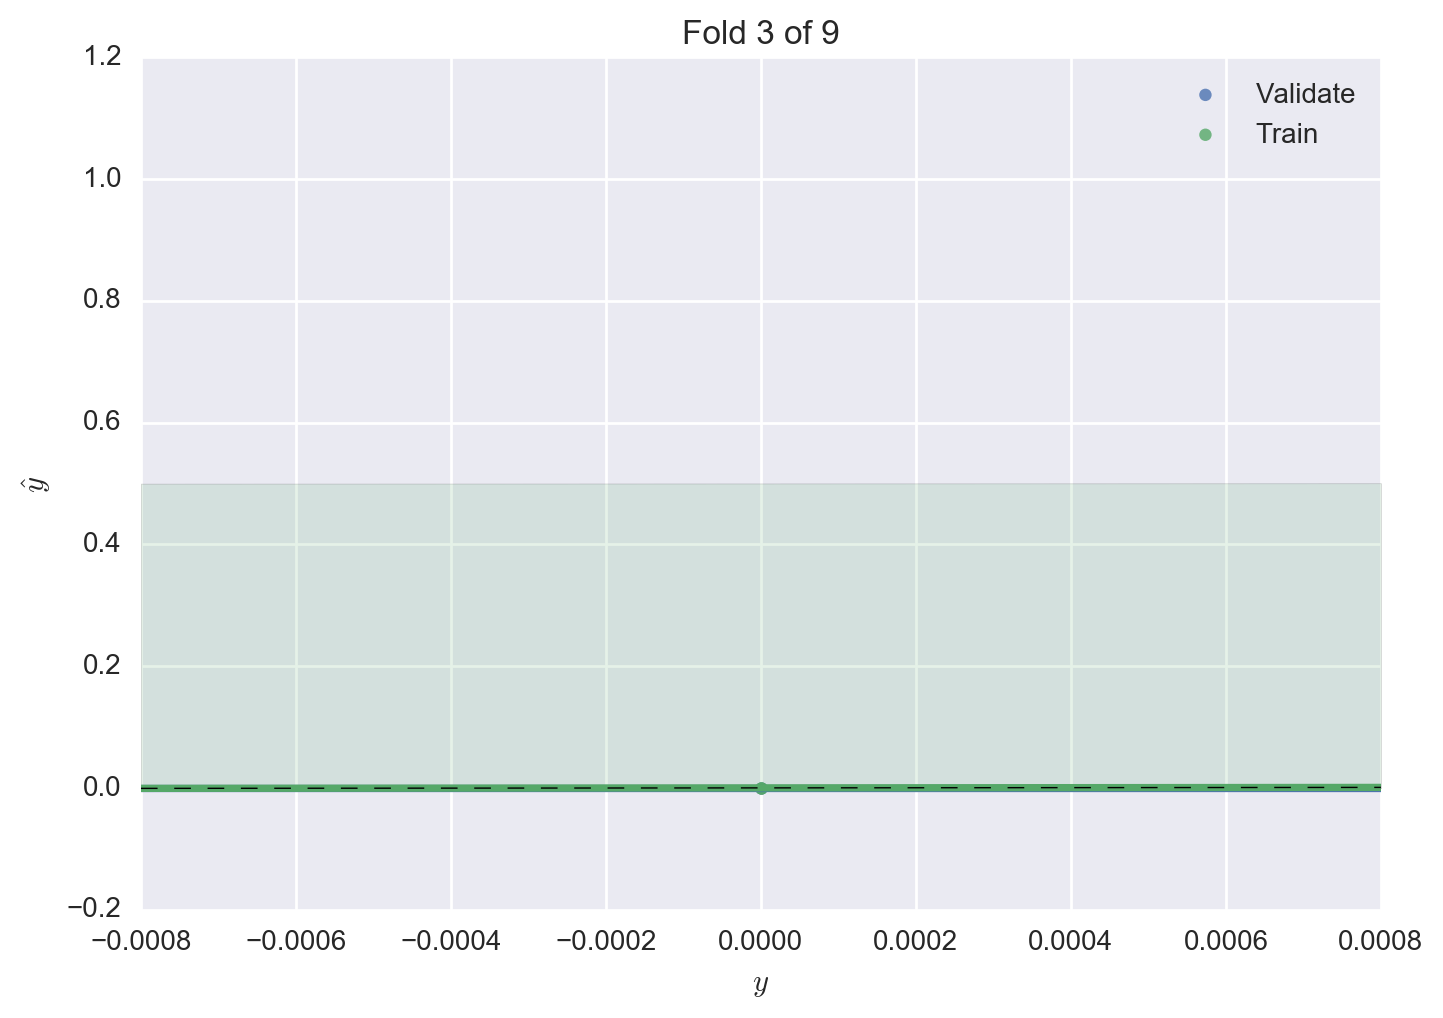

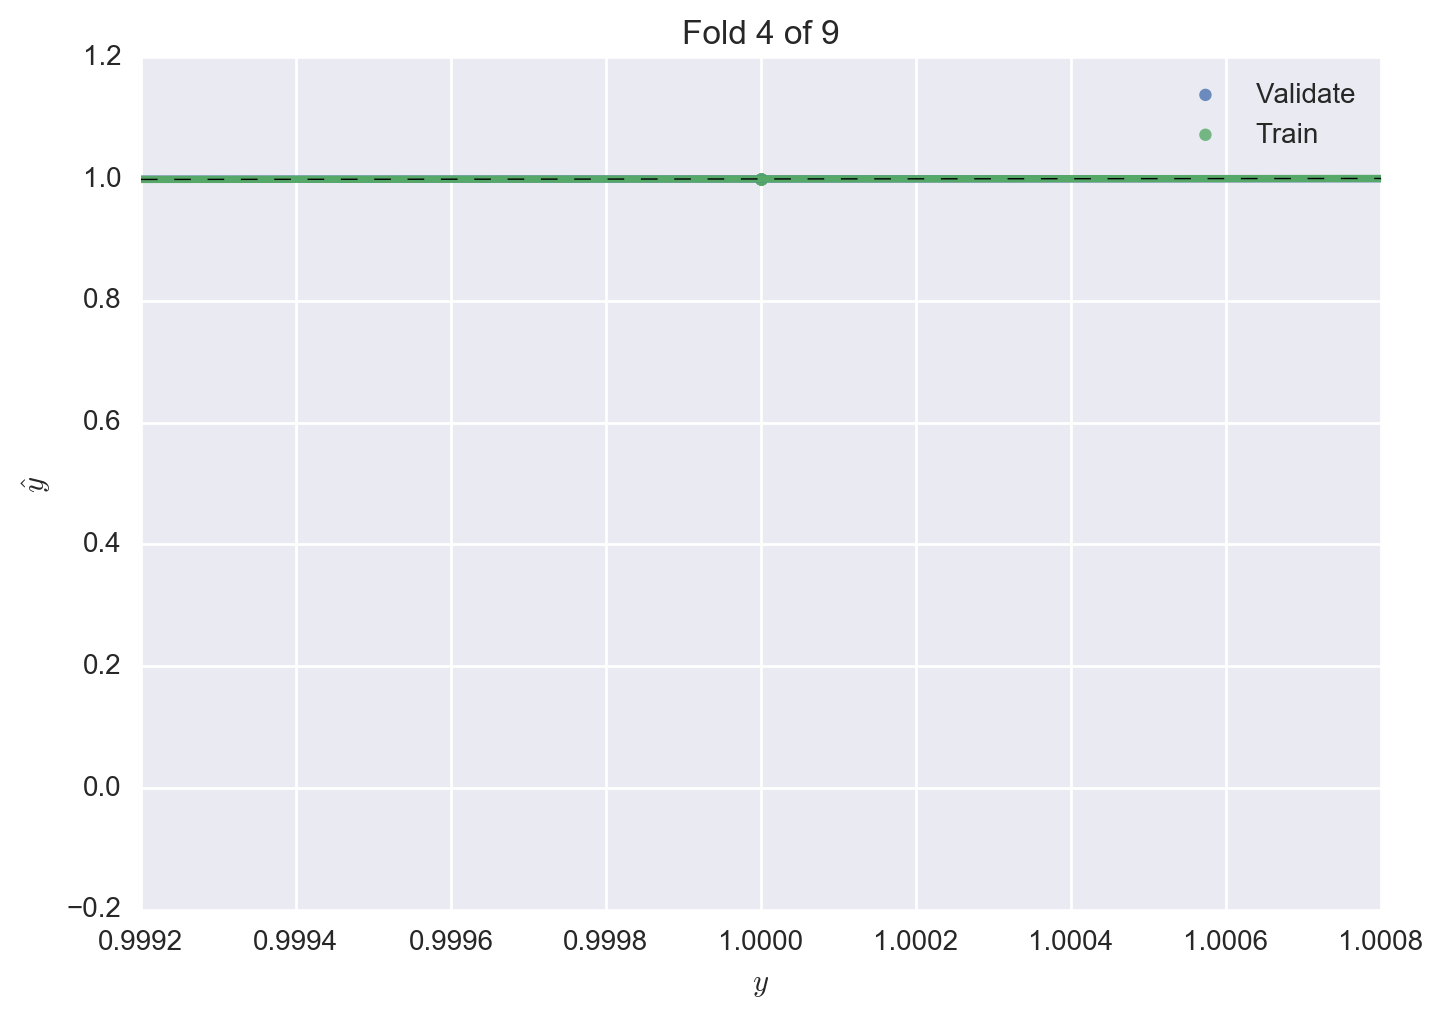

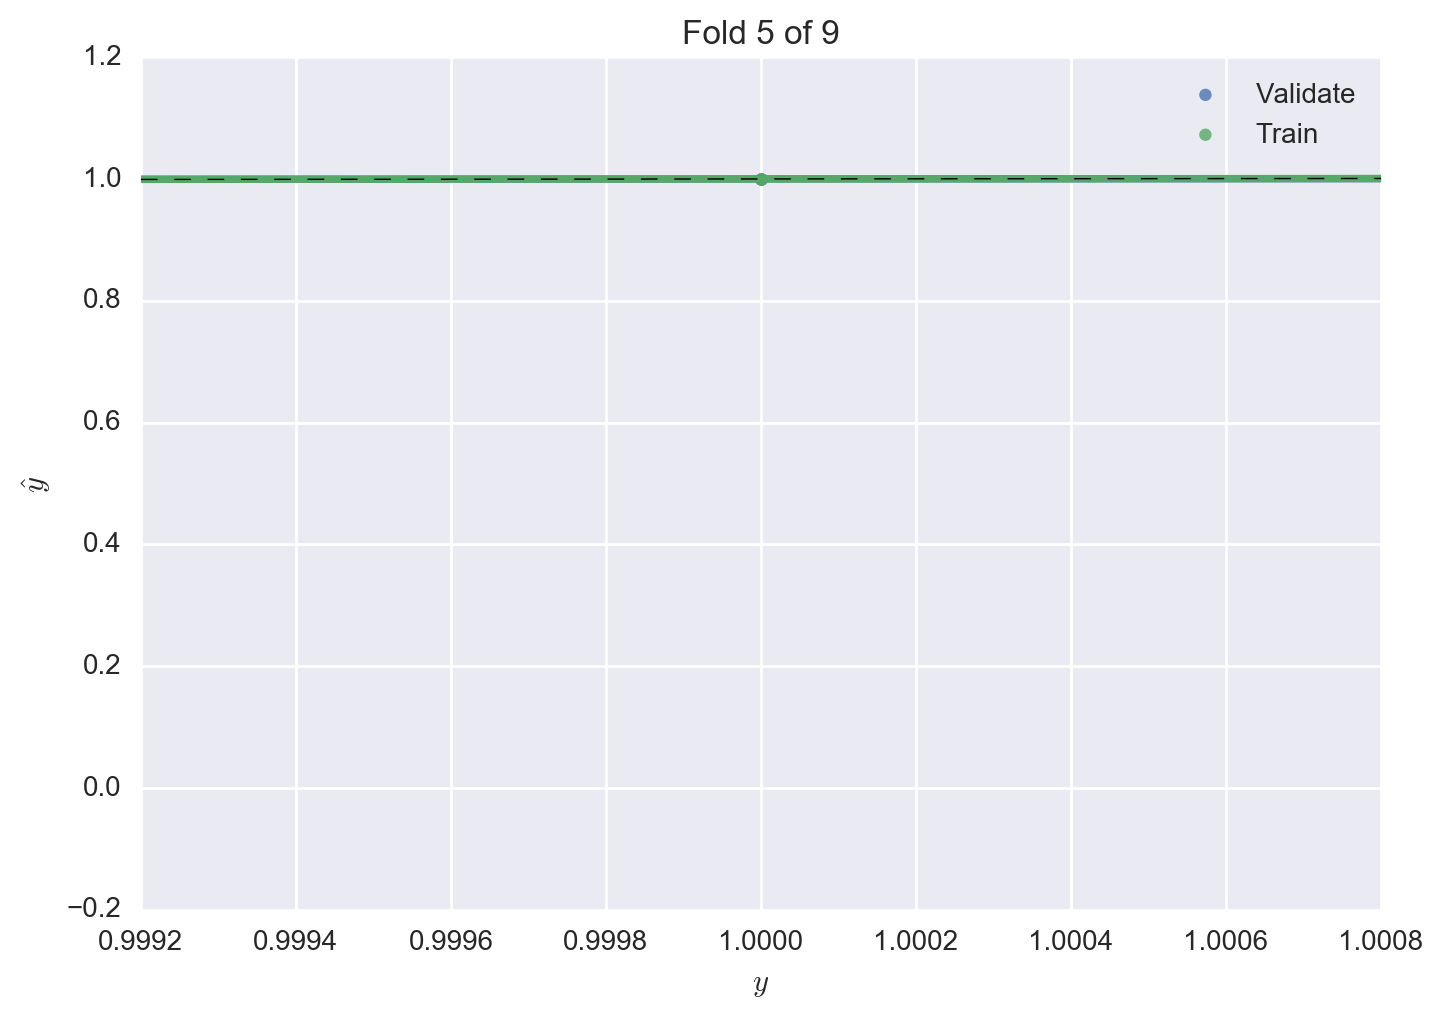

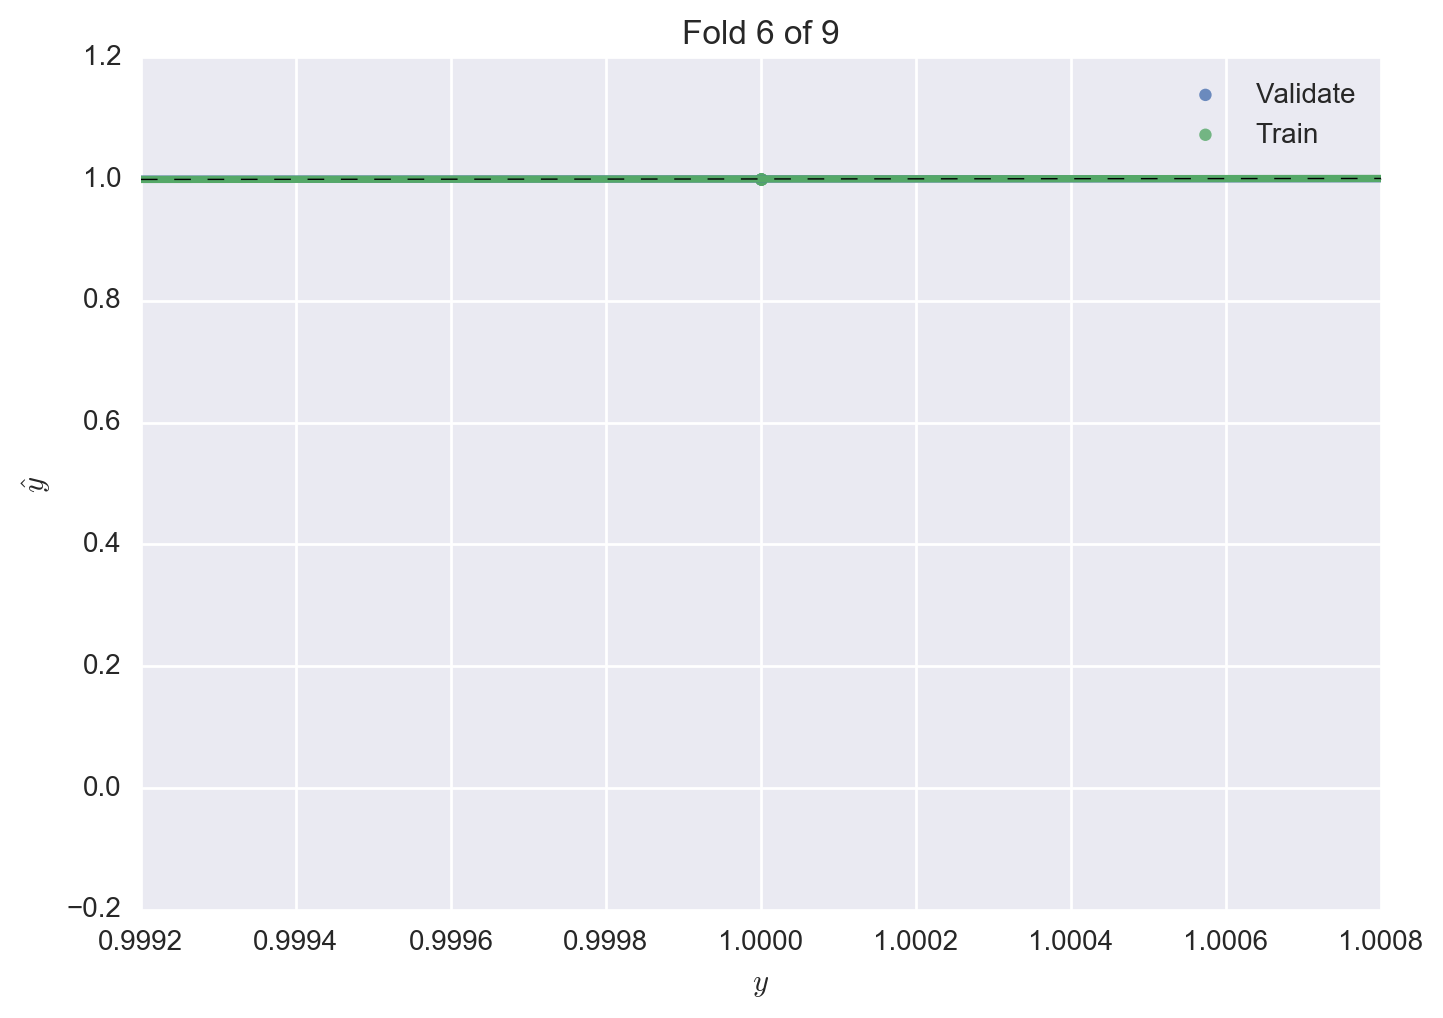

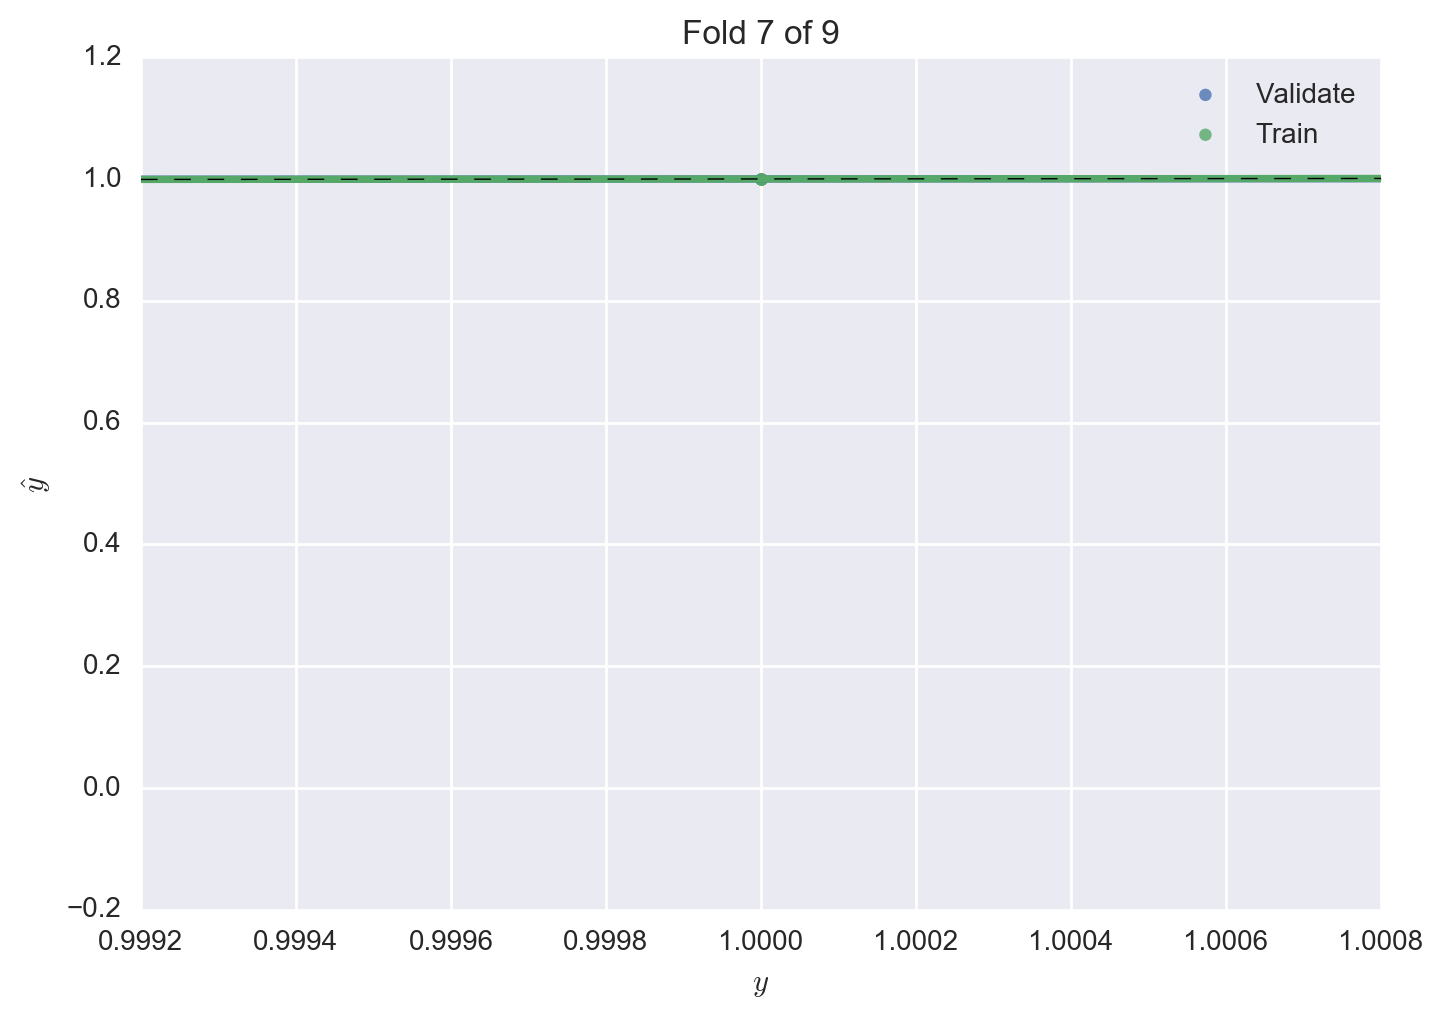

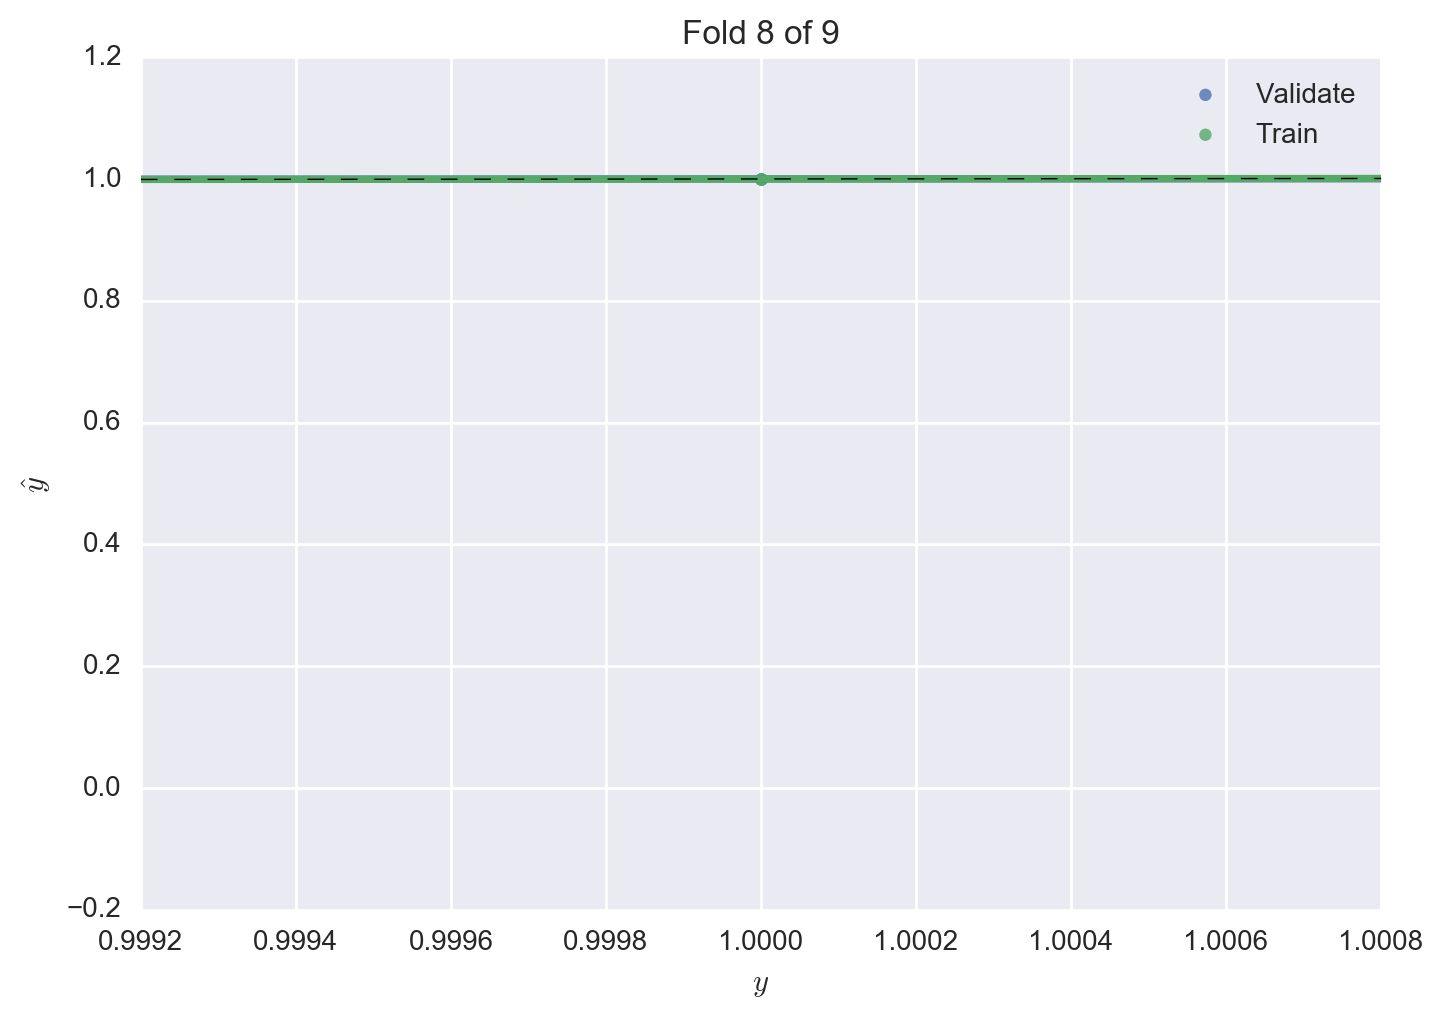

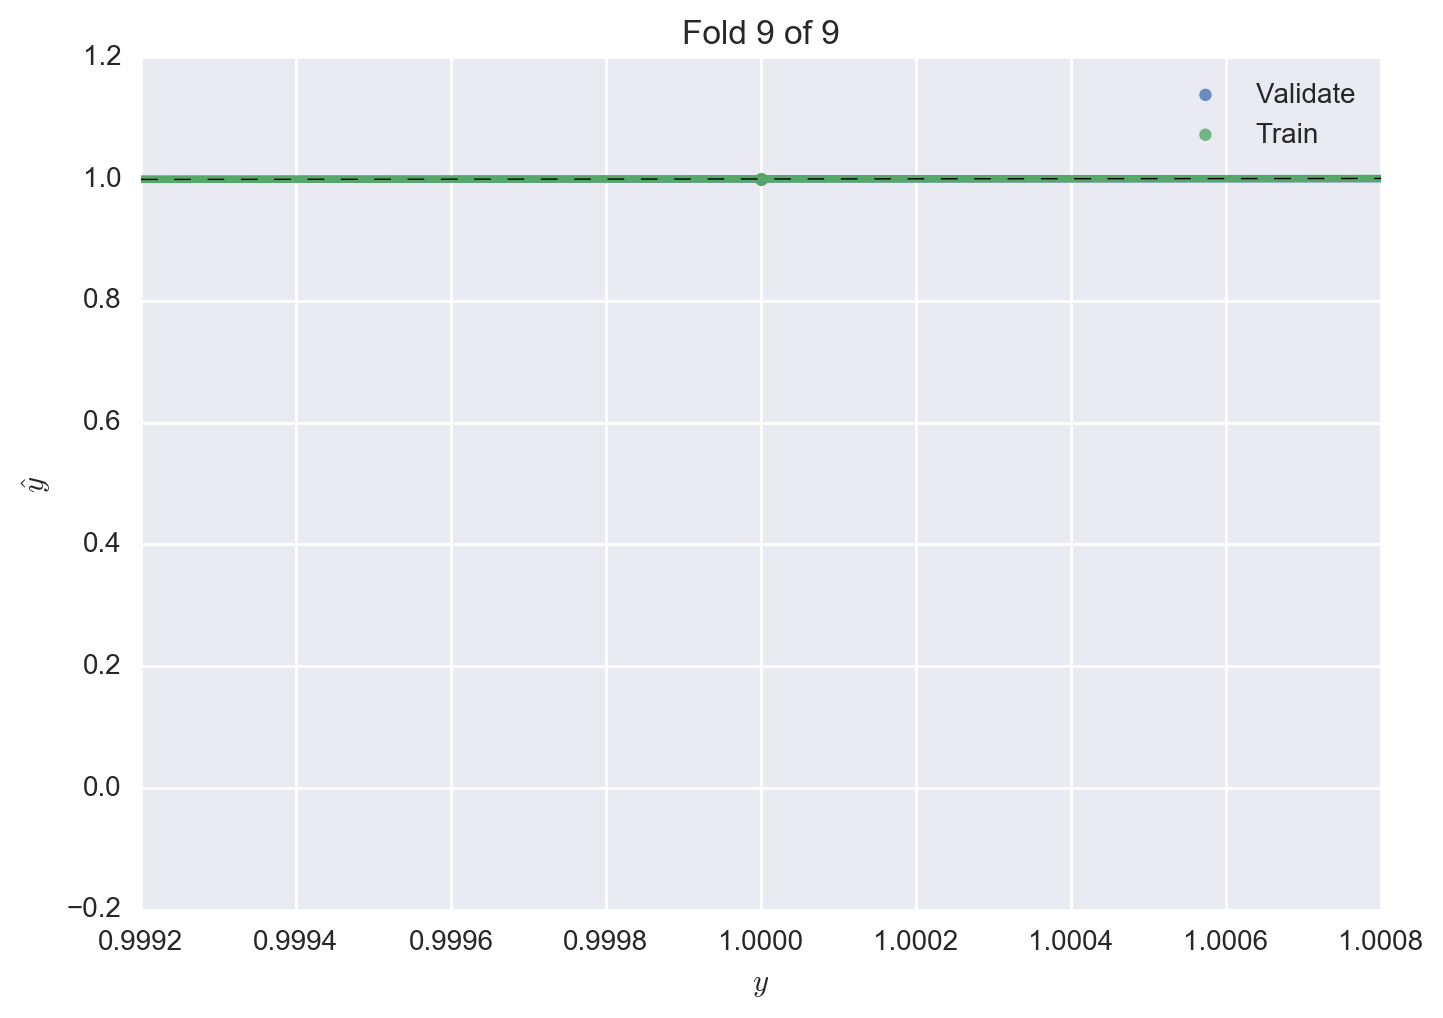

In [7]:
cv_obj.cross_validate()

mean accuracy score 0.89, standard error 0.31
INFO:root:All accuracy scores: [1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
mean sensitivity 0.67, standard error 0.47
INFO:root:All sensitivity scores: [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
mean specificity 0.00, standard error 0.00
INFO:root:All specificity scores: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
mean precision 0.67, standard error 0.47
INFO:root:All precision scores: [0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]f


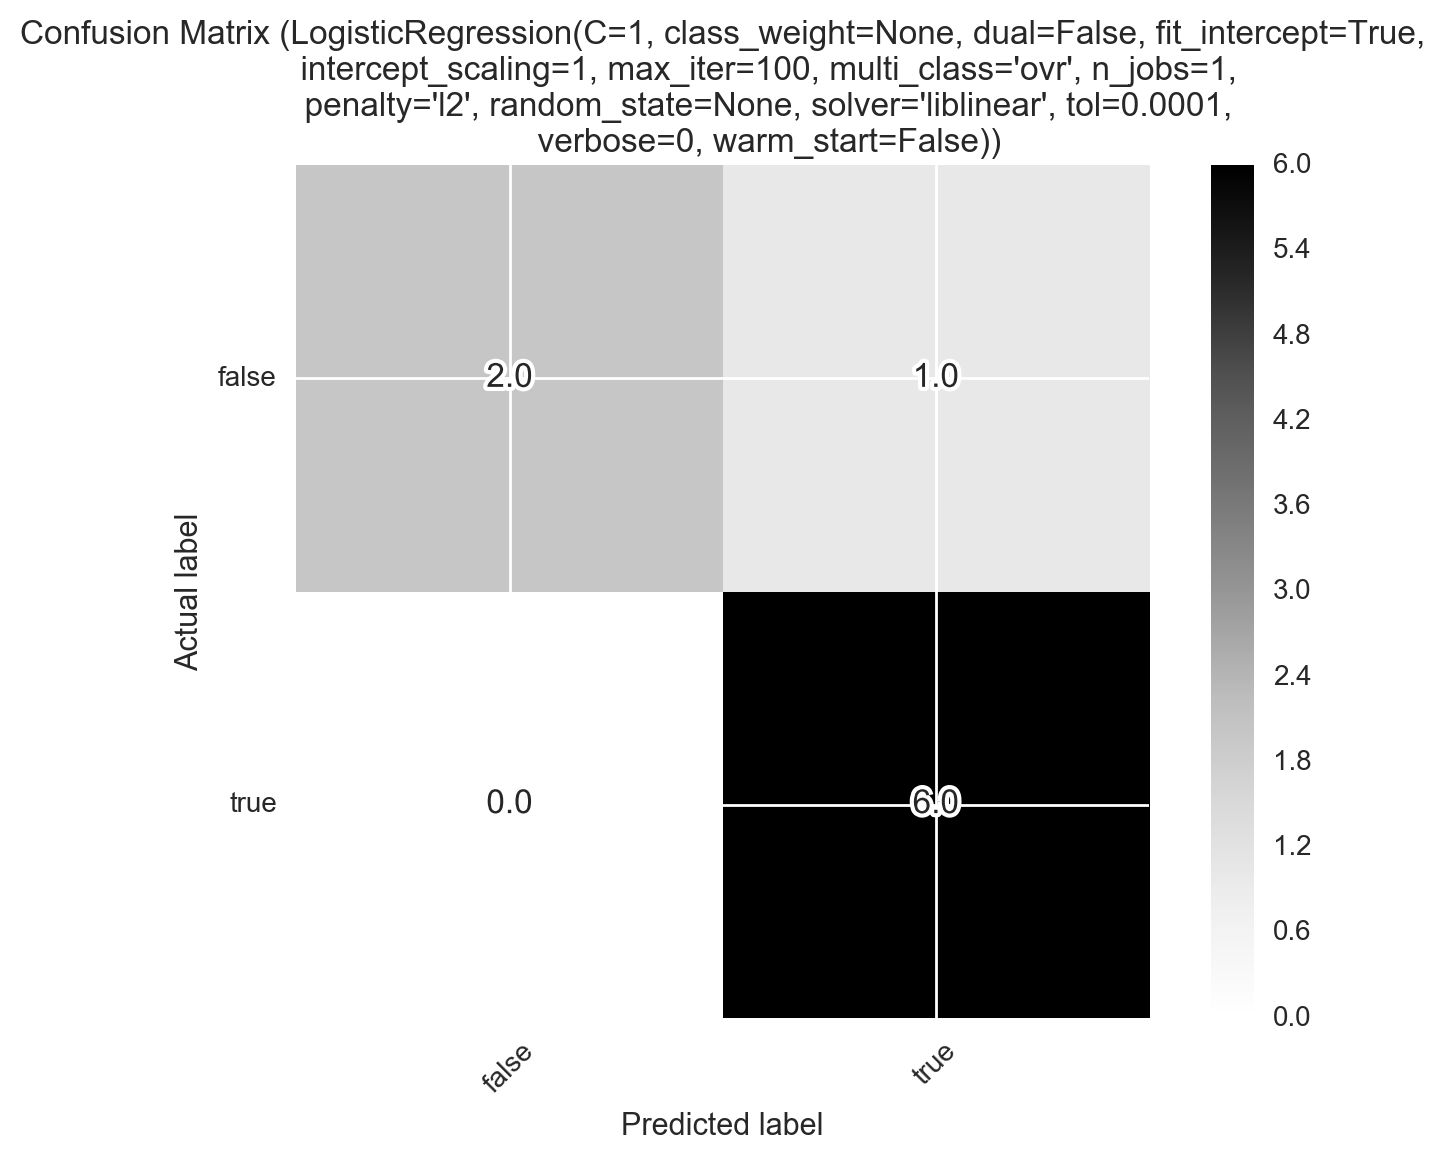

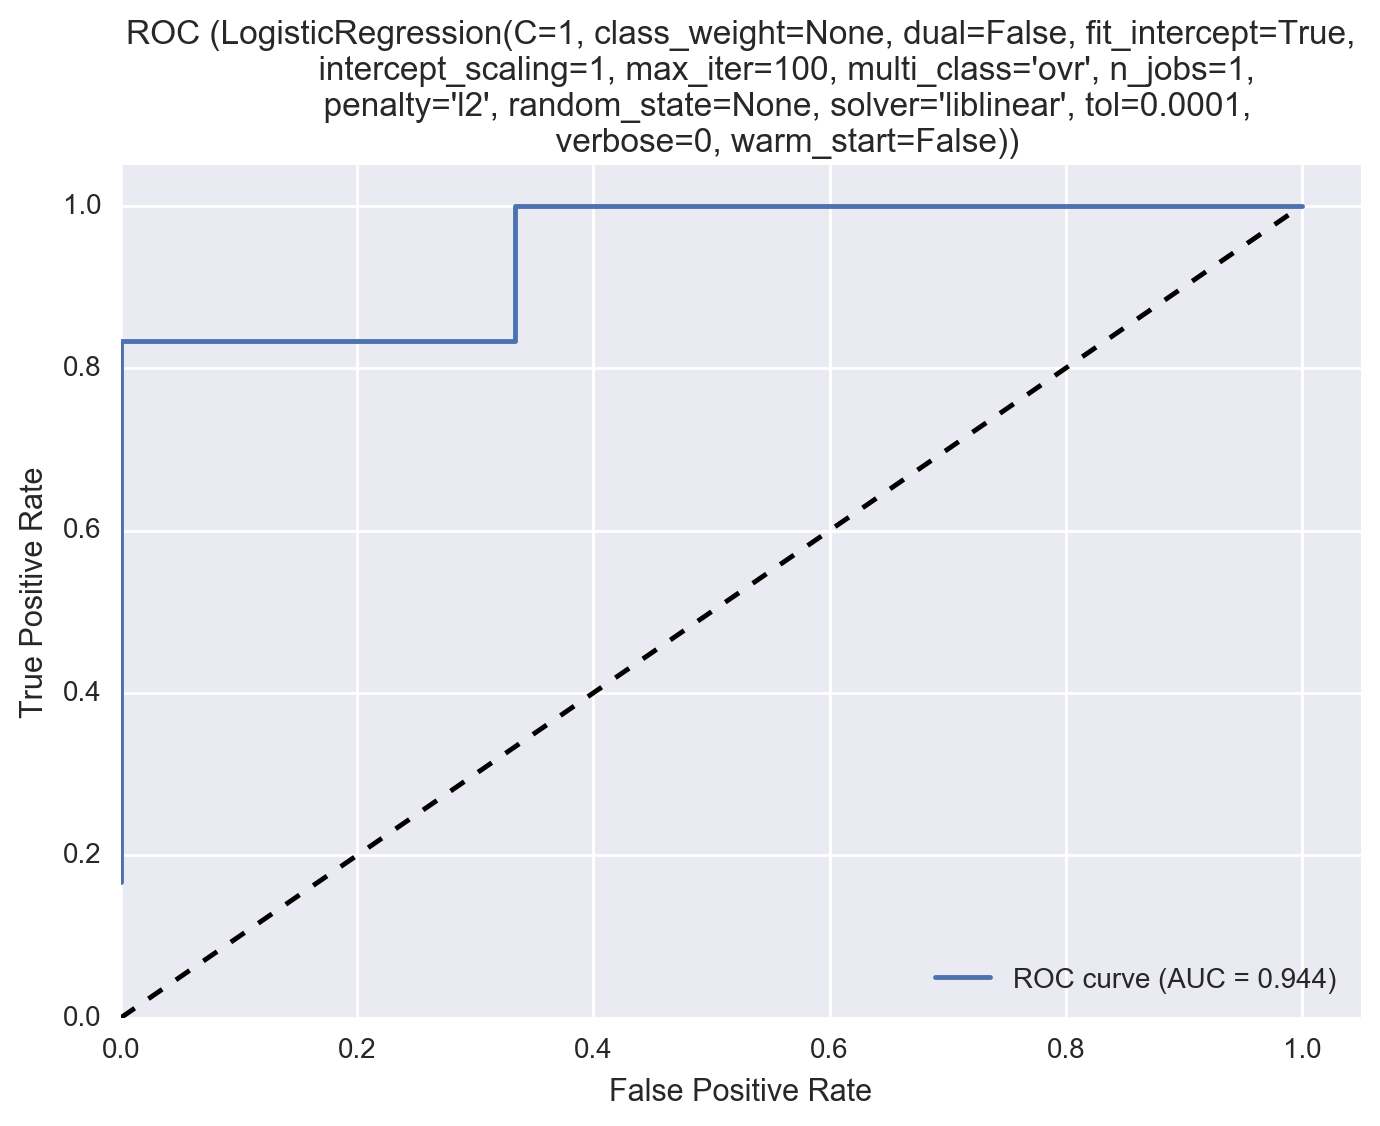

In [8]:
cv_obj.output_results()

⇒ one false positive; patient 4

### Look at $\beta_i$s

#### Look at all the data for feature weights

In [9]:
all_data_model = sklearn.linear_model.LogisticRegression()
all_data_model.fit(X=data_object.independentDF, y=data_object.dependentDF.as_matrix().ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

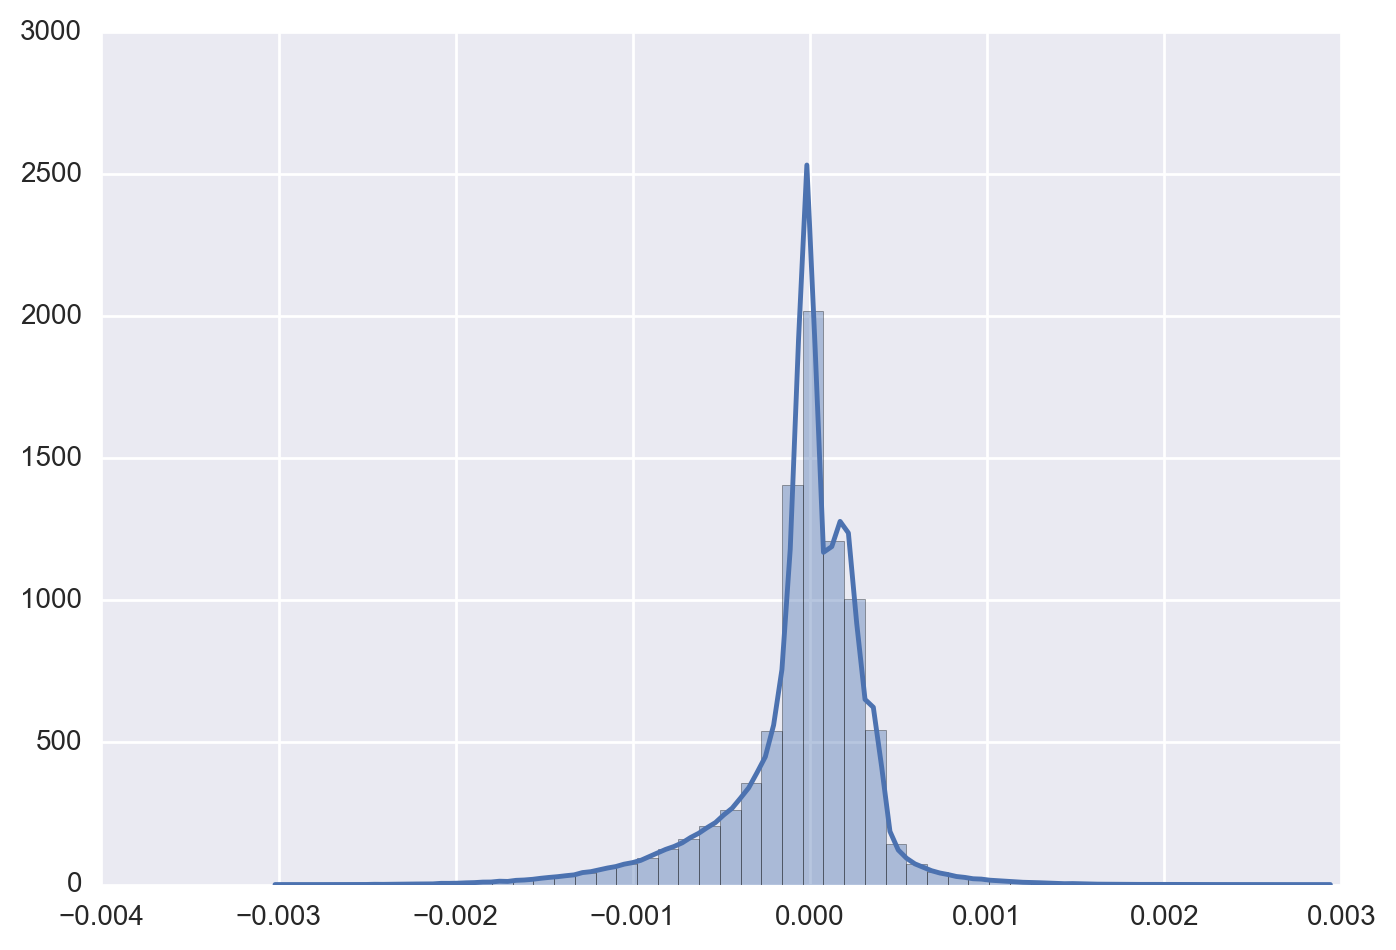

In [10]:
sns.distplot(all_data_model.coef_.T.flatten())

More density negative ⇒ more negative $\beta_i$s ⇒ less methylation means HM ⇒ consistent with Matt's findings

In [11]:
big_coef_idx = abs(all_data_model.coef_.T.flatten()) > 0.0026
big_coef_cols = data_object.independentDF.columns.get_values()[big_coef_idx]
sns.set()
sns.clustermap(data_object.independentDF[big_coef_cols])

In [12]:
coef_df = pd.DataFrame({"coefs":all_data_model.coef_[:,big_coef_idx].ravel(), 
             "cg": big_coef_cols}).set_index("cg").sort_values(by="coefs", ascending=False)

#### Annotate $\beta_i$s

In [13]:
cg_database = pd.read_csv("/Users/ijoseph/Code/Data/Genome-Annotation/Methylation/master.cg.database.csv").set_index("cg")

In [14]:
pd.set_option('max_rows', 34)
annot_coef_df = pd.DataFrame.join(coef_df, cg_database, how='left').sort_values(by="coefs", ascending=False)[["coefs", "nearestGeneSymbol", "distance"]]
annot_coef_df.reindex(annot_coef_df.coefs.abs().order(ascending=False).index)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: order is deprecated, use sort_values(...)
  app.launch_new_instance()


coefs nearestGeneSymbol  distance
cg                                              
cg26411280 -0.002965          FLJ45079      4061
cg10028884 -0.002926              PER1         0
cg01897500 -0.002917          FLJ45079      3826
cg08190858  0.002882         HOXC13-AS      7764
cg15680720  0.002845         LINC01124       535
cg19122720 -0.002844          FLJ45079      4179
cg01615880 -0.002825             NHSL1         8
cg10179669 -0.002817            KCNK10         0
cg19187410 -0.002807          FLJ45079      3723
cg13236881 -0.002769              PON2       306
cg08248516  0.002764          HOXA-AS3         0
cg06881310 -0.002759             NHSL1        49
cg14893576 -0.002751            KLHL29      4094
cg07161429 -0.002732            CHST11         0
cg16907514 -0.002707          KTN1-AS1         0
cg02330264 -0.002696            KCNK10         0
cg21656205 -0.002682             RIMS4       708
cg22202131 -0.002680            PGRMC2        34
cg23483512 -0.002678          FLJ45079      4157
cg22586726  0.002674            LRRC27         0
cg21884421 -0.002674            IGDCC3         0
cg10051493  0.002664             MEIOB      5062
cg21370255  0.002659            LRRC27         0
cg12347792 -0.002655           CCDC110       554
cg15579148 -0.002638              PON2       309
cg17450930 -0.002635            REPIN1       189
cg02354125 -0.002633             LEKR1         0
cg02535060  0.002626            LRRC27         0
cg05773628 -0.002626            NCKAP1       183
cg23685650 -0.002618          KTN1-AS1         0
cg25076597  0.002612            LRRC27         0
cg14874351 -0.002606             LIN7A       150
cg00357532 -0.002606            NCKAP1       156
cg22397446 -0.002601              PHC2         0

## Support Vector Classifier

INFO:root:Fold 4: difference between predicted and acutal:
[0]
vs
Patient.ID
HM_21    1
Name: HM.ind, dtype: int64


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ijoseph/Code/workspace/FactorAssociationAnalysisCancerGenomics/Jupyter-Notebooks/Prediction/../../Performance/classification/CrossValidation.py:74: RuntimeWarning: invalid value encountered in divide
  specificity = [TN / float(FP+ TN)])


mean accuracy score 0.89, standard error 0.31
INFO:root:All accuracy scores: [1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
mean sensitivity 0.56, standard error 0.50
INFO:root:All sensitivity scores: [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
mean specificity nan, standard error nan
INFO:root:All specificity scores: [0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0]
mean precision 0.56, standard error 0.50
INFO:root:All precision scores: [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]f


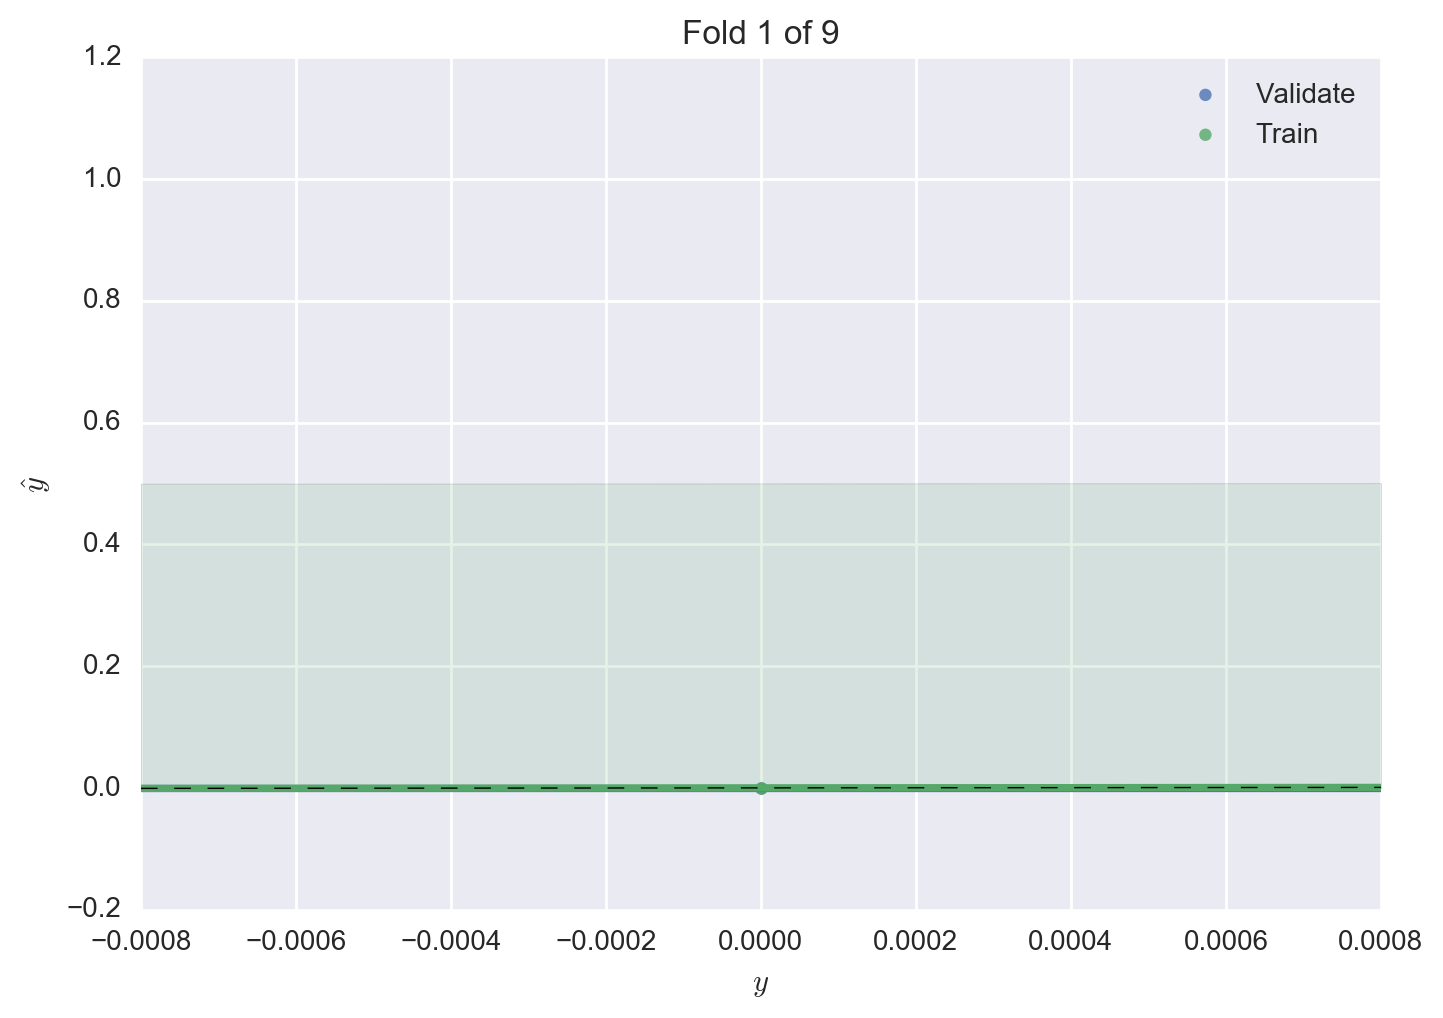

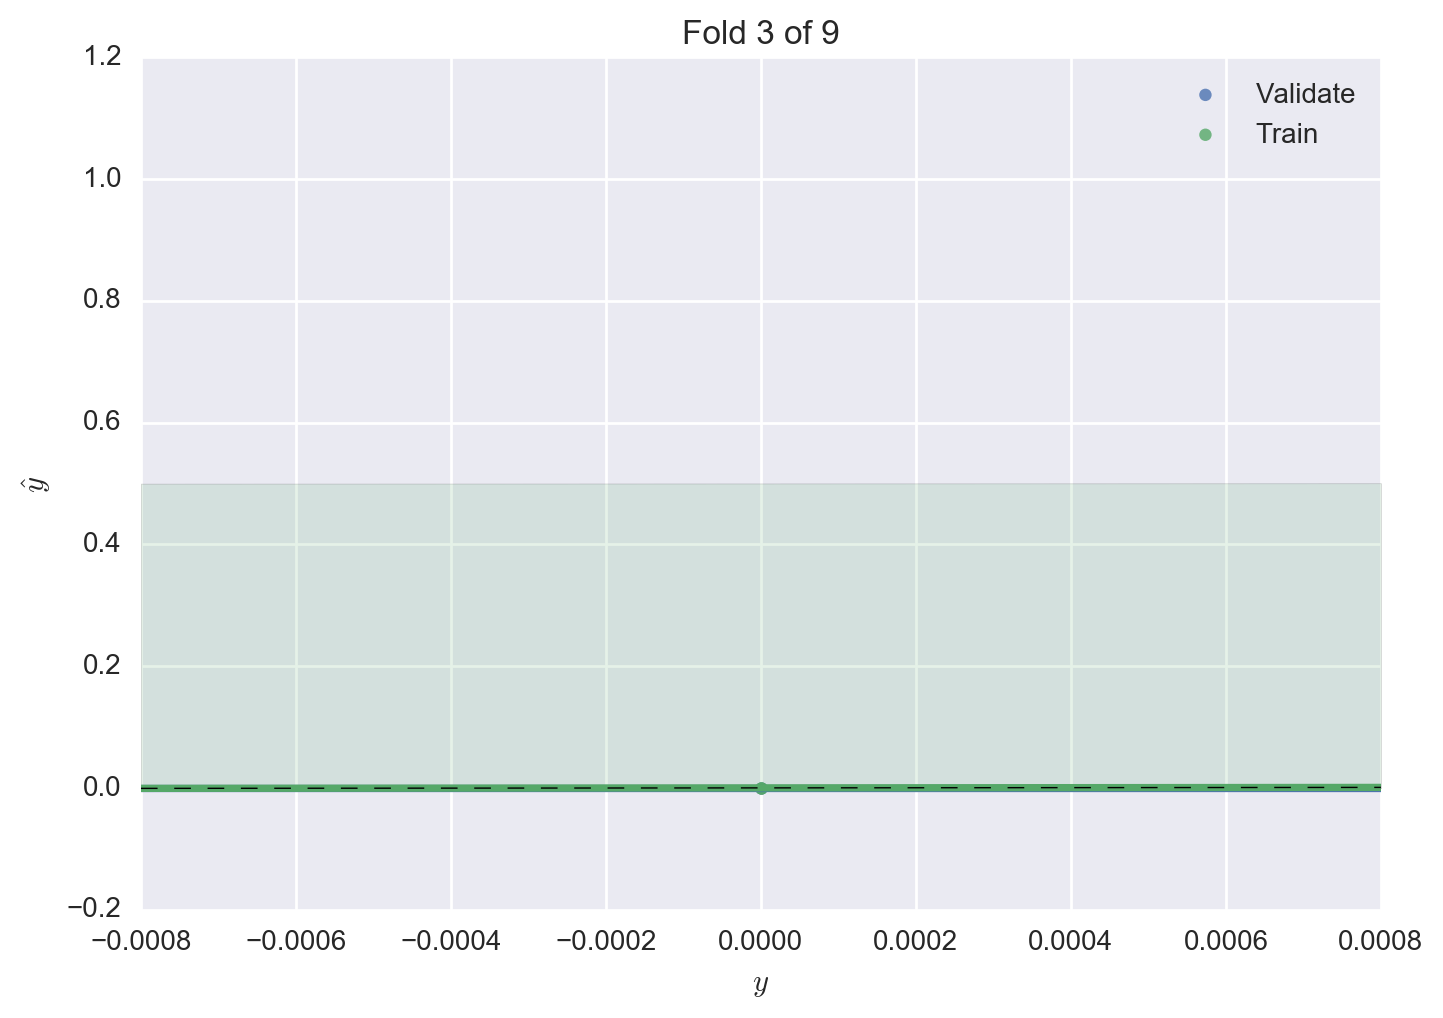

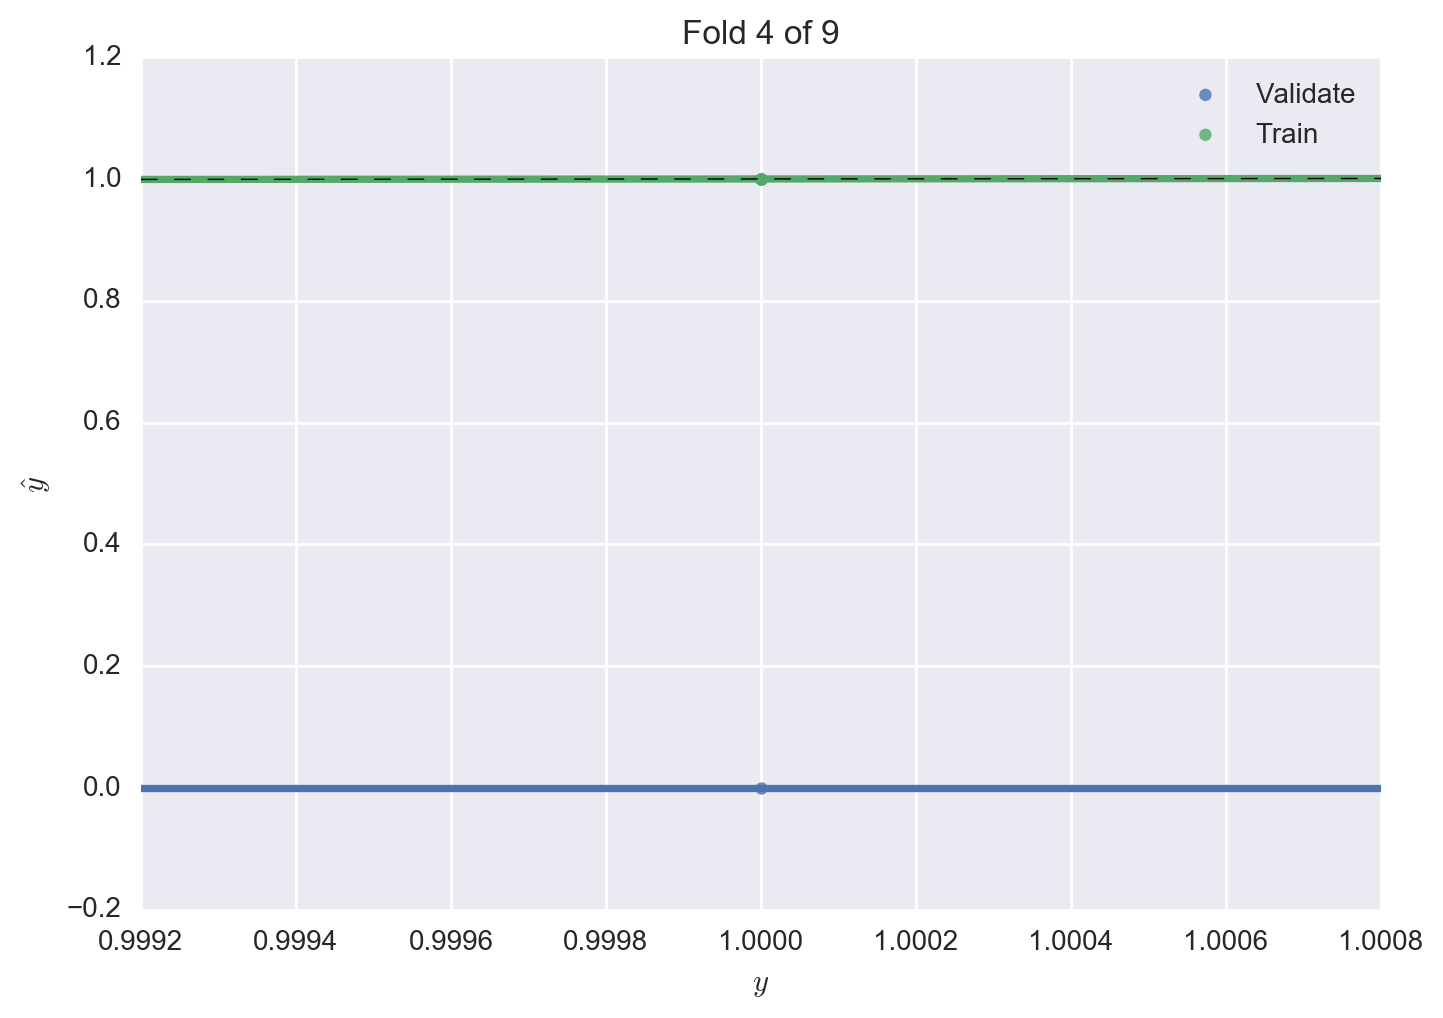

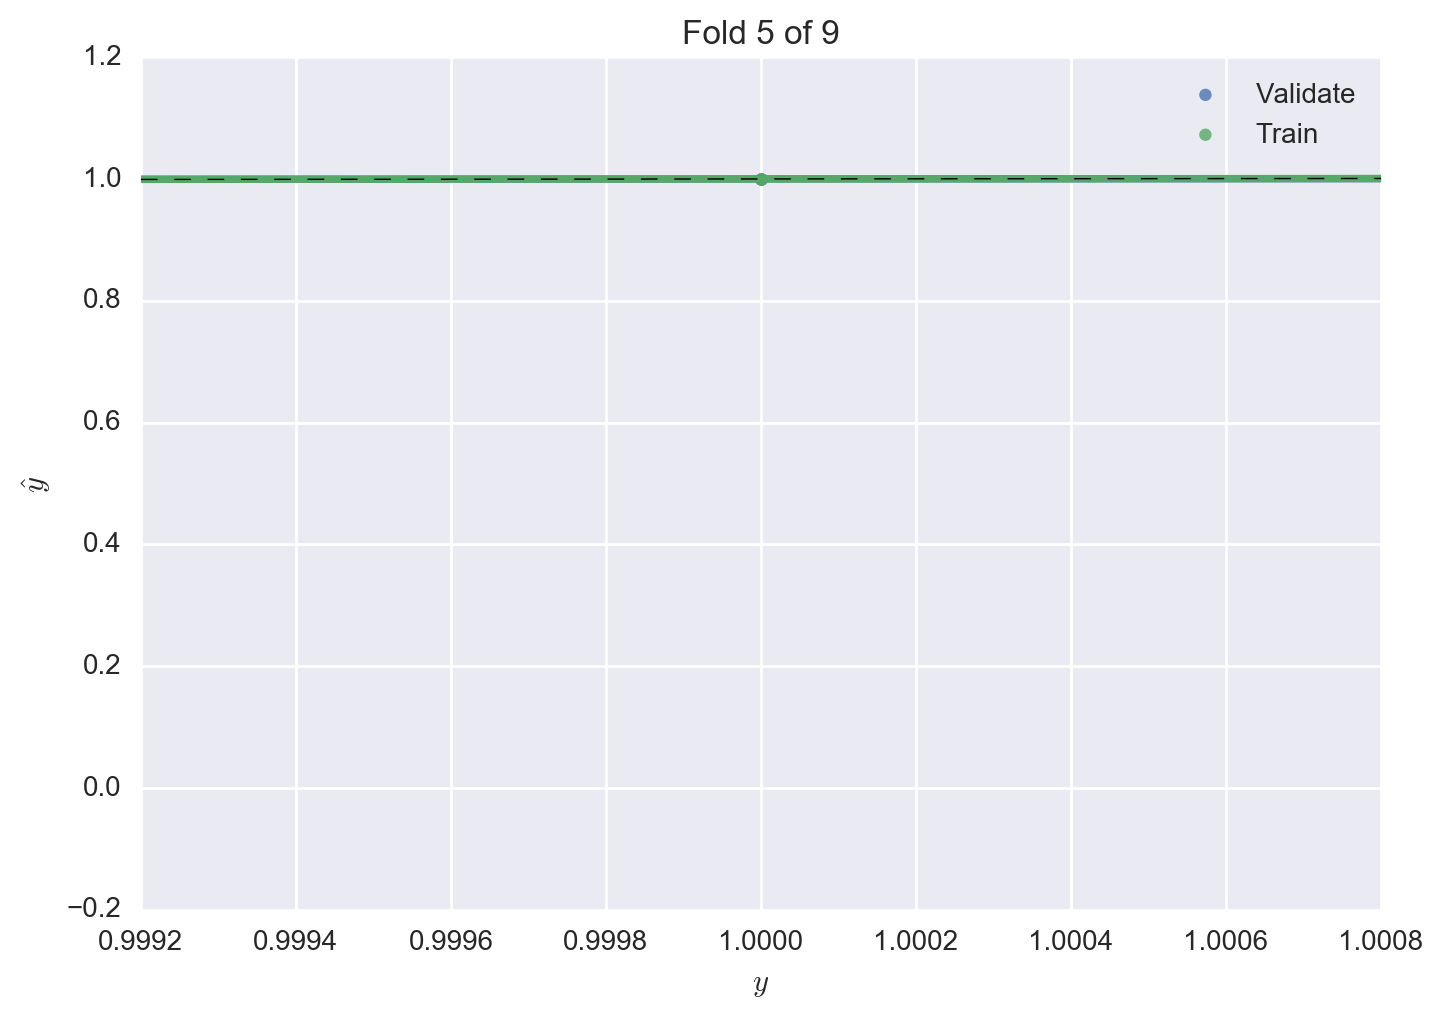

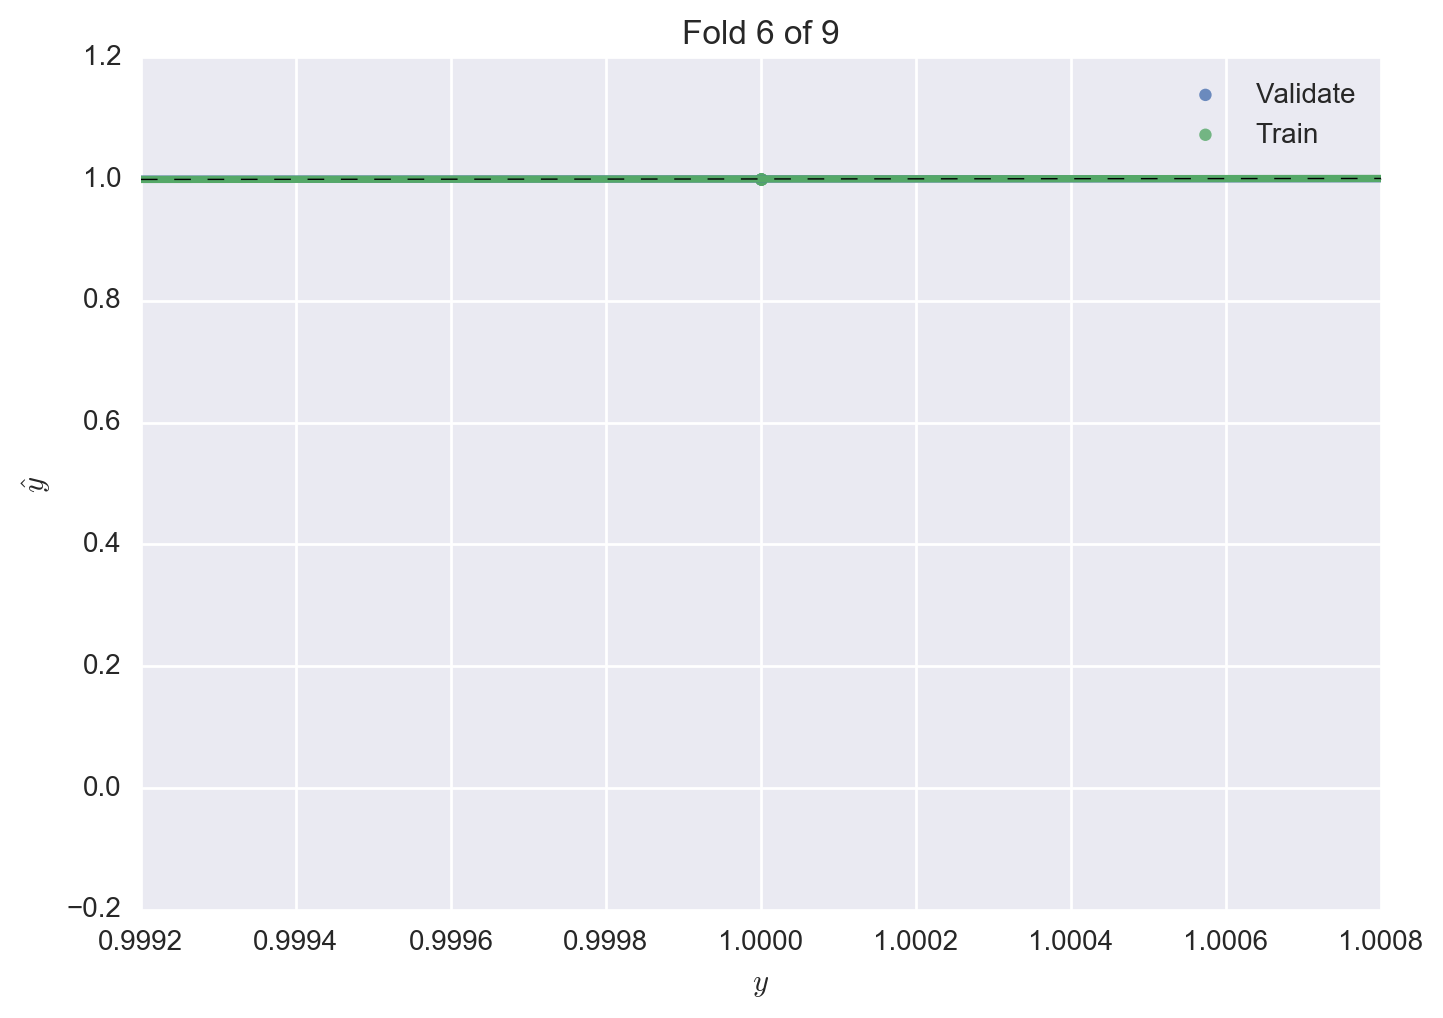

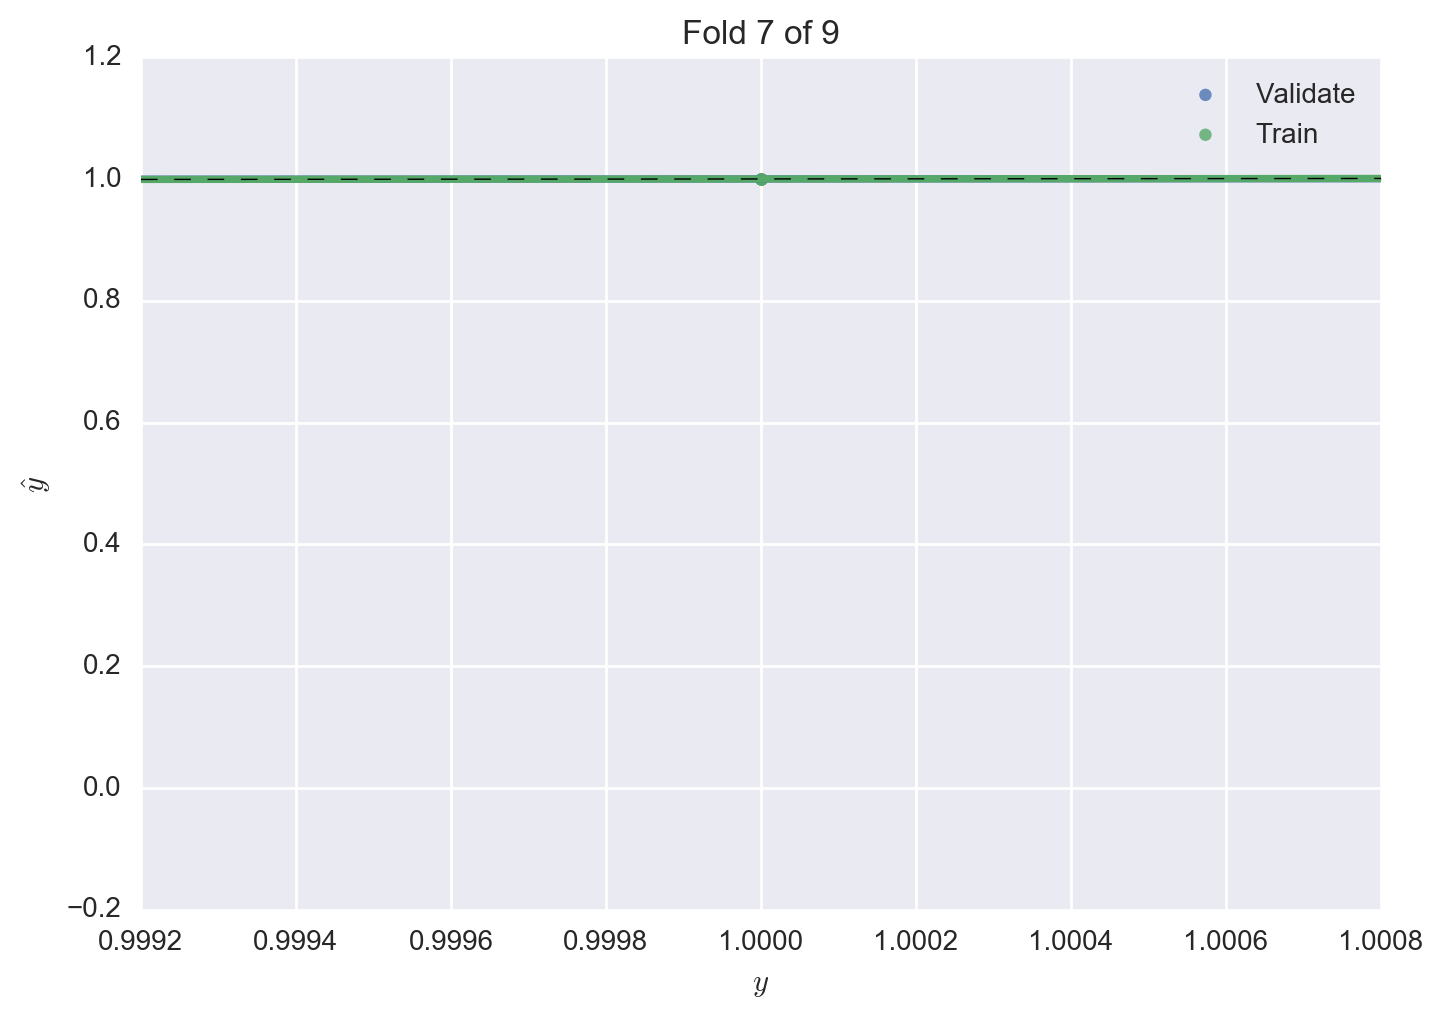

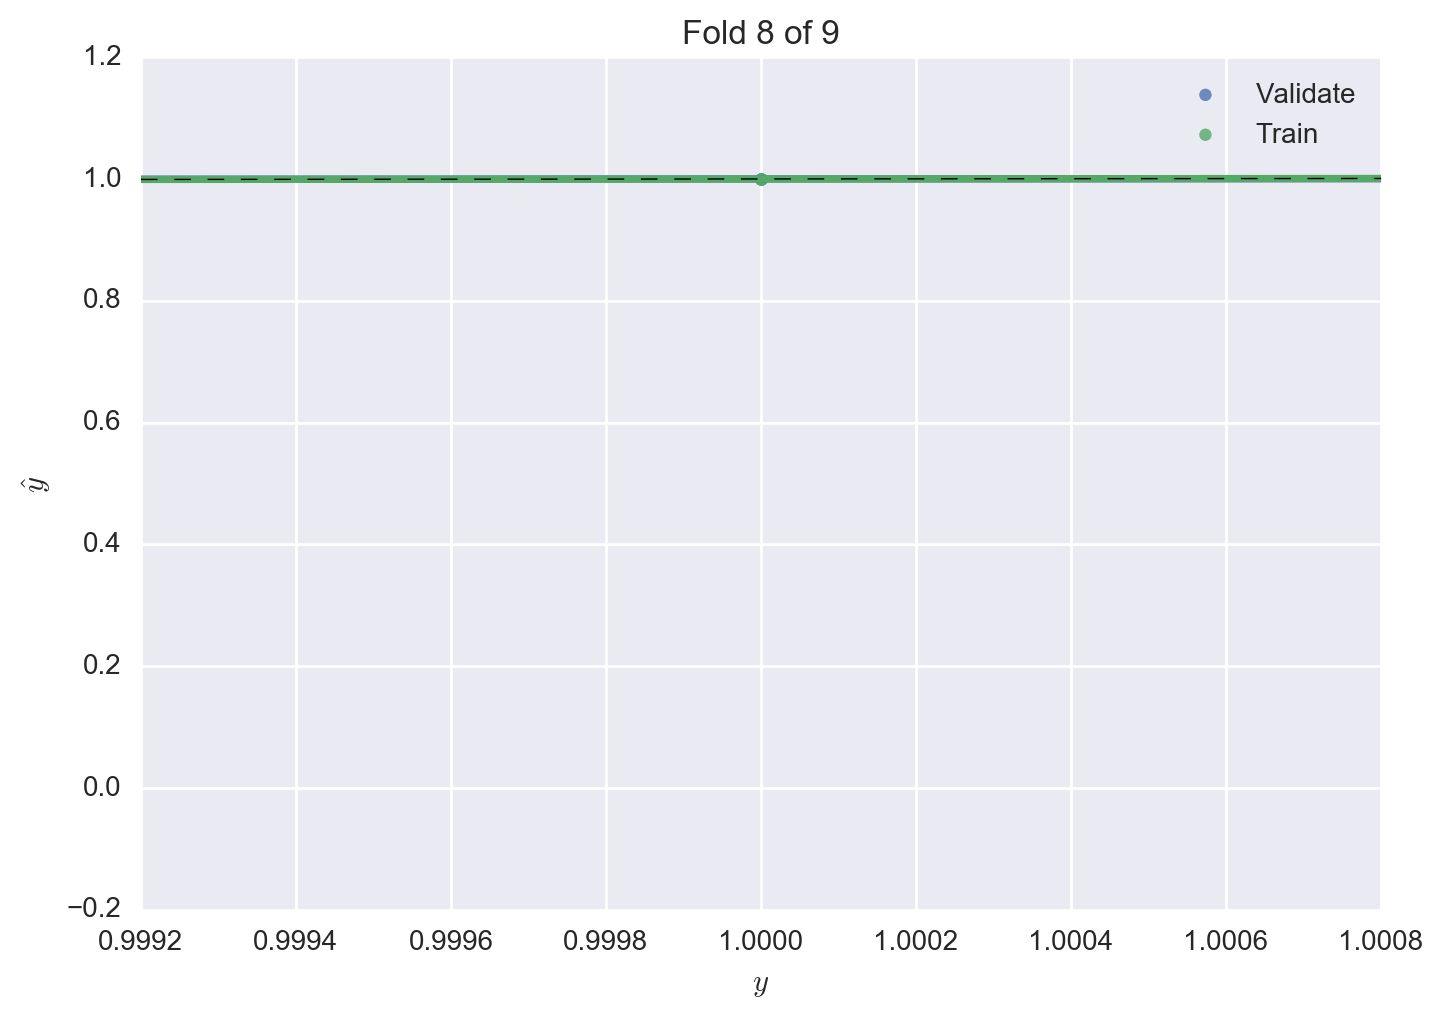

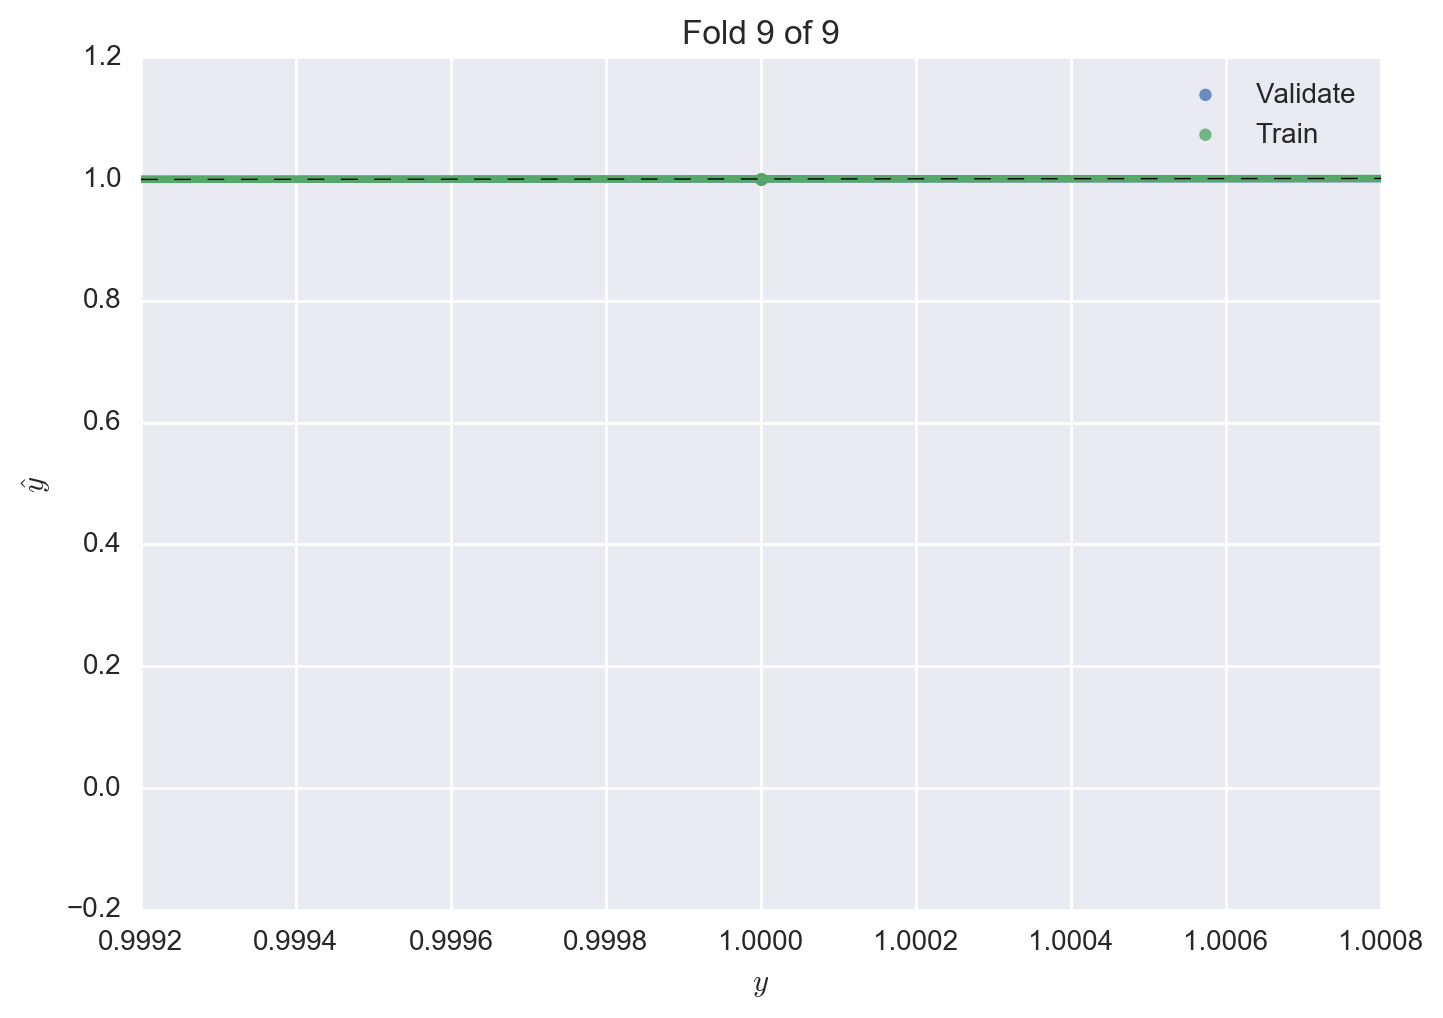

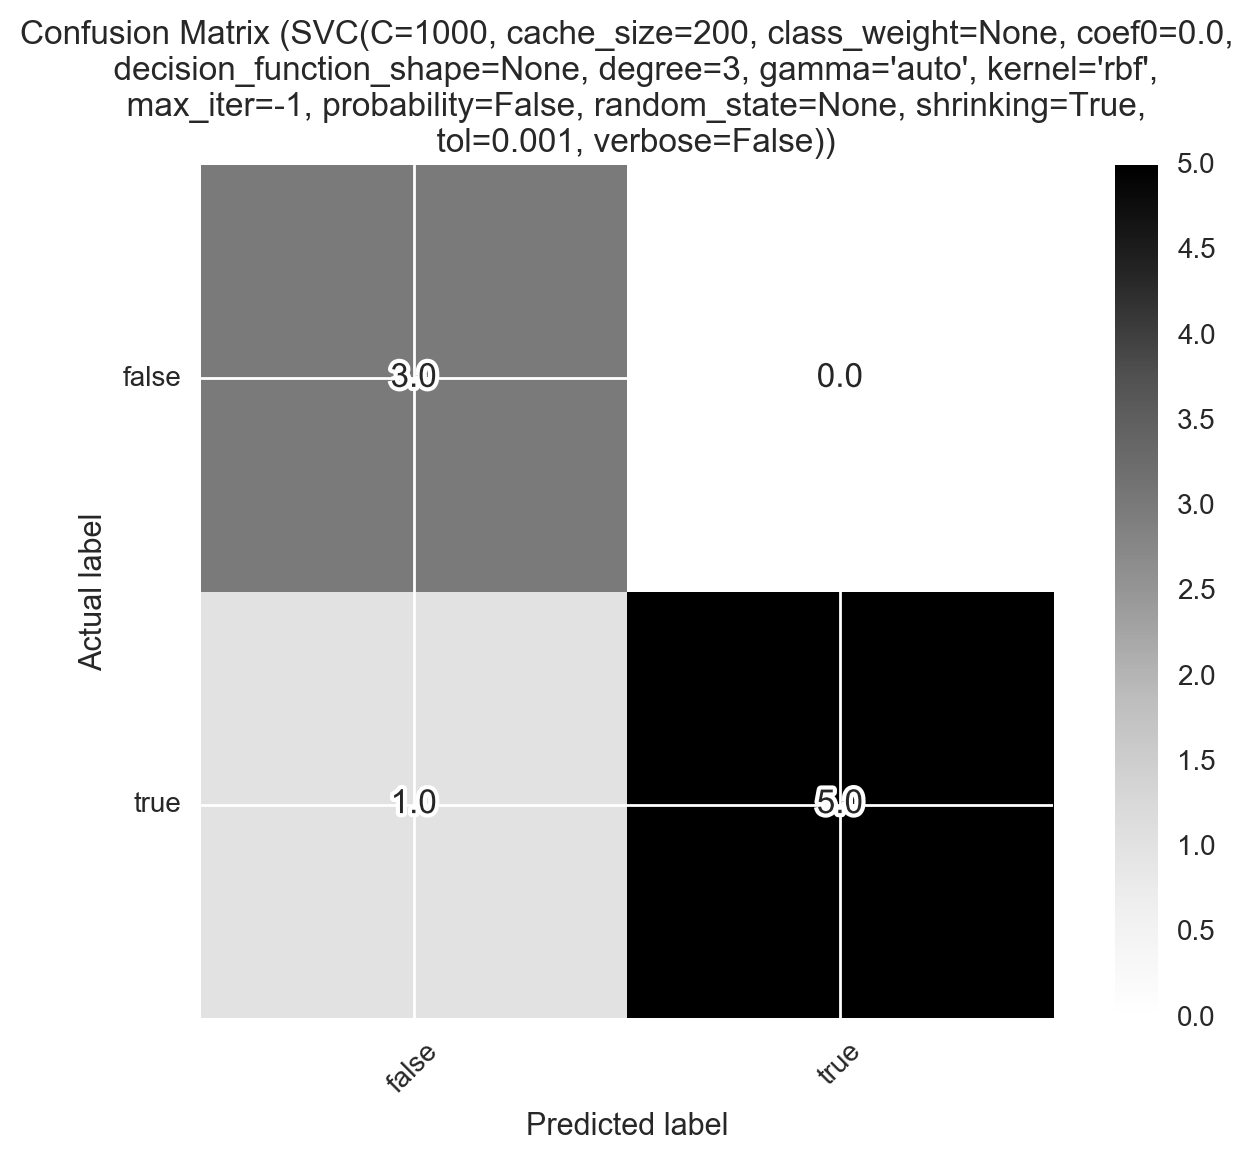

In [16]:
model = sklearn.svm.SVC(C=1000)
cv_obj_svc = Performance.classification.CrossValidation.CrossValidation \
(dataFrameCollection=data_object, predictorClass=model, k=9)
cv_obj_svc.cross_validate()
cv_obj_svc.output_results()

⇒ one false negative: patient 21